# Causal Inference Project: Impact of Scholarships on Student Success
---
**Main Research Questions:**
1. Does receiving a scholarship reduce the likelihood of dropping out within 3 years?
2. Does receiving a scholarship increase the likelihood of graduating within 3 years?

We apply **Double Machine Learning (DML)** and **Random Forests** to estimate causal effects using observational data from the UCI dataset _"Predict students dropout and academic success"_.

# Part 0 - Preprocessing

## Import Libraries

In [85]:
# Fundamental scientific computing libraries
import numpy as np  # Provides support for large, multi-dimensional arrays and matrices
import pandas as pd  # Used for data manipulation and analysis

# Double Machine Learning (DML) for causal inference
import doubleml as dml  # Implements DoubleML methods for causal machine learning

# Scikit-learn: Machine learning and preprocessing utilities
from sklearn.preprocessing import PolynomialFeatures  # Generates polynomial feature combinations
from sklearn.linear_model import LassoCV, LogisticRegressionCV  # Lasso regression with cross-validation and logistic regression with cross-validation
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # Random Forest models for classification and regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  # Decision Tree models for classification and regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Standardizes features (scaling) and encodes categorical variables
from sklearn.pipeline import make_pipeline  # Simplifies workflow creation with preprocessing and model steps
from sklearn.model_selection import train_test_split  # Splits data into training and testing sets

# XGBoost: Optimized gradient boosting library
from xgboost import XGBClassifier, XGBRegressor  # XGBoost models for classification and regression

# Data visualization libraries
import matplotlib.pyplot as plt  # Standard plotting library
import seaborn as sns  # Enhances visualization capabilities with statistical plots
from IPython.display import display

from importlib import reload
# import declarations as d #Importing a custom module named 'declarations' as 'd'
# reload(d)

In [86]:
#!pip install declarations

## Load and Import the Dataset

In [87]:
# Jort
# df=pd.read_csv(r"C:\Users\jortk\OneDrive\OneDrive Documenten\ENSAE\ENSAE ML for Econometrics\Project\data.csv", sep=";")

# Jakob
# df=pd.read_csv("/Users/jakob/Documents/Parforceleistung/Studium/MSc Economics/Semester 4/Machine Learning for Econometrics/Project/data.csv", sep=";")
df = pd.read_csv('data.csv', sep=';')

# Anushka
# from google.colab import drive
# drive.mount('/content/drive')
# df=pd.read_csv("/content/drive/MyDrive/dropoutdata.csv", sep=";")

# Lucie
# df=d.fetch_ucirepo(id=697)
# X=df.data.features
# y = df.data.targets
# df = d.pd.concat([X, y], axis=1)
# X.head() # Display the first few rows of the dataset to get an overview

In [88]:
# Print dataset description
print("Dataset Description:")

# Dictionary containing descriptions of dataset features
dataset_description = {
    "target": "Student status: Graduate, Dropout, or Enrolled",
    "Course": "Study program the student is enrolled in",
    "Age at enrollment": "Age of the student at the time of enrollment",
    "Gender": "Binary indicator (0 = Male, 1 = Female)",
    "Scholarship holder": "Binary indicator for receiving a scholarship (0 = No, 1 = Yes)",
    "Tuition fees up to date": "Indicator if tuition fees are paid (0 = No, 1 = Yes)",
    "Debtor": "Indicator if the student has outstanding debts (0 = No, 1 = Yes)",
    "Admission grade": "Grade obtained at admission",
    "Previous qualification": "Previous academic qualification of the student",
    "Previous qualification grade": "Grade obtained in the previous qualification",
    "Displaced": "Indicator if the student is displaced (0 = No, 1 = Yes)",
    "Educational special needs": "Indicator for special education needs (0 = No, 1 = Yes)",
    "International": "Indicator if the student is international (0 = No, 1 = Yes)",
    "Mother's qualification": "Educational qualification of the student's mother",
    "Father's qualification": "Educational qualification of the student's father",
    "Mother's occupation": "Occupation of the student's mother",
    "Father's occupation": "Occupation of the student's father",
    "Unemployment rate": "Unemployment rate in the country during enrollment",
    "GDP growth rate": "GDP growth rate at the time of enrollment",
    "Inflation rate": "Inflation rate at the time of enrollment"
}
# Loop through the dictionary and print each feature's description
for var, desc in dataset_description.items():
    print(f"{var}: {desc}")

Dataset Description:
target: Student status: Graduate, Dropout, or Enrolled
Course: Study program the student is enrolled in
Age at enrollment: Age of the student at the time of enrollment
Gender: Binary indicator (0 = Male, 1 = Female)
Scholarship holder: Binary indicator for receiving a scholarship (0 = No, 1 = Yes)
Tuition fees up to date: Indicator if tuition fees are paid (0 = No, 1 = Yes)
Debtor: Indicator if the student has outstanding debts (0 = No, 1 = Yes)
Admission grade: Grade obtained at admission
Previous qualification: Previous academic qualification of the student
Previous qualification grade: Grade obtained in the previous qualification
Displaced: Indicator if the student is displaced (0 = No, 1 = Yes)
Educational special needs: Indicator for special education needs (0 = No, 1 = Yes)
International: Indicator if the student is international (0 = No, 1 = Yes)
Mother's qualification: Educational qualification of the student's mother
Father's qualification: Educational qua

## Other small edits

In [89]:
# Set notebook styling for better visuals
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

#Check for missig values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

# Standardize column names (fix spacing issues)
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Convert target Variable to Binary (Dropout = 1, Others = 0)
df["binary_target"] = df["target"].apply(lambda x: 1 if x == 'Dropout' else 0)

Missing values per column:
 Series([], dtype: int64)


### Note on Missig Data
The Series([], dtype: int64) indicates that the missing_values Series is empty. This means there are no missing values in any of the dataset columns. Thus, no missing value imputation is needed (e.g., filling with mean/median/mode or dropping rows) and the dataset is clean and ready for preprocessing or model training.
The data consists of 4424 observations and is supported by program SATDAP - Capacitação da Administração Pública under grant POCI-05-5762-FSE-000191, Portugal. We use Target as our outcome variable, Y, in our analysis.

# Part 1 - PICO Formulation

### **PICO Formulation for Analyzing the Impact of Scholarships and Gender on Student Dropout**  

#### **Population (P):**  
Undergraduate students enrolled in various programs (e.g. agronomy, design, education, etc.) at a Portuguese university​. The dataset contains 4,424 students with information on their demographics (age, gender, nationality), family background (parents’ education and occupation), socio-economic status (e.g. regional GDP, unemployment rate), and prior academic performance (high school grades, admission exam scores). All students began their degrees around the same time, and we observe their status 3 years after enrollment.

#### **Intervention (I):**  
Receiving a **scholarship** (binary treatment: 1 = scholarship holder, 0 = non-scholarship holder). Scholarships provide **financial aid**, which may help students remain enrolled and complete their degrees. In this dataset, about 24.8% of students received a scholarship. Scholarship assignment is not randomized – it may depend on merit and/or need, so treated and untreated students may differ in important ways (to be addressed by controlling for confounders).

#### **Comparison (C):**  
We compare **students who received a scholarship vs. those who did not**, while holding constant other factors. Key potential **confounders** include:

- **Academic preparation:** prior qualification grade, admission exam grade (students with better prior grades might both win scholarships and have lower dropout risk).
By controlling for these covariates, we attempt to isolate the effect of scholarships. We will also examine effect modification by gender, i.e., whether the scholarship’s impact differs for male vs. female students.
- **Socio-economic status:** whether the student is displaced (moved for studies), family’s education, regional economic indicators (unemployment, inflation, GDP) that might correlate with both scholarship allocation (often need-based) and dropout.
- **Demographics:** gender, age at enrollment, international student status, etc., which could influence scholarship decisions or educational outcomes.

#### **Outcome (O):**  
Student status 3 years after enrollment. The original outcome is categorical: Dropout, Enrolled (still studying), or Graduate (finished degree in 3 years). For causal analysis, we focus on two binary outcomes corresponding to our RQs:

- RQ1. (Dropout within 3 years): 1 if Dropout, 0 if still enrolled or graduated. This measures whether the student failed to persist (drop out) within the 3-year window. 
- RQ2. (Graduation within 3 years): 1 if Graduated, 0 if not (i.e., still enrolled or dropped out by 3 years). This captures timely degree completion.

The central questions are whether scholarships causally decrease the dropout rate and increase the graduation rate within the standard time.

#### **Assumptions:**
We assume no unobserved confounding – i.e., given our covariates, scholarship status is as good as random (Ignorability). This requires that factors influencing both scholarship awards and student success (like academic merit and financial need) are adequately captured in our data. We also assume positivity (both scholarship and non-scholarship students exist at each combination of covariates) and SUTVA (one student’s treatment doesn’t directly affect another’s outcome). These are standard assumptions for causal inference​. Violation of these (for example, an unmeasured confounder like “intrinsic motivation” or teacher recommendations affecting both scholarship and success) could bias our results.

This PICO framework guides the analysis by helping us **quantify the causal effect of scholarships and gender on student success** while accounting for **potential confounders** using **Double Machine Learning (DML).**

# Part 2 - Exploratory data analysis (EDA): descriptive analysis, association and visualization

## Visualization of the Target variable distribution

/var/folders/2t/48g1hgqx30s07cfsvjg95f4w0000gn/T/ipykernel_2063/692941155.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, palette="pastel")


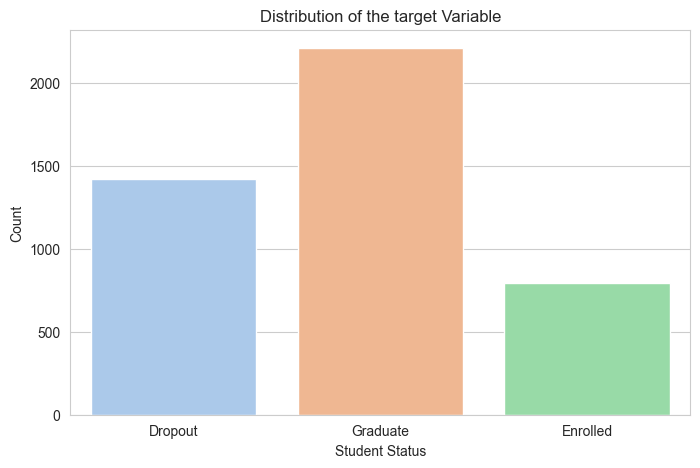

In [90]:
plt.figure(figsize=(8, 5))
sns.countplot(x="target", data=df, palette="pastel")
plt.title("Distribution of the target Variable")
plt.xlabel("Student Status")
plt.ylabel("Count")
plt.show()

Most students graduate within 3 years, while a substantial fraction drop out. Out of 4,424 students, 2,209 (50%) graduated on time, 1,421 (32%) dropped out, and 794 (18%) were still enrolled after 3 years. The high graduation rate reflects the dataset’s outcome imbalance (many more successes than dropouts), which we will account for in modeling. Reducing the 32% dropout is a key concern for policymakers.

### Binary Outcome Creation

In [91]:
df['dropout_3y'] = (df['target'] == 'Dropout').astype(int)
df['graduated_3y'] = (df['target'] == 'Graduate').astype(int)
# df['scholarship'] = (df['scholarship_holder'] == 'yes').astype(int)

In [92]:
# Summary stats
print('Scholarship rate:')
print(df['scholarship_holder'].value_counts(normalize=True))
print('\nDropout rate:')
print(df['dropout_3y'].value_counts(normalize=True))
print('\nGraduation rate:')
print(df['graduated_3y'].value_counts(normalize=True))

Scholarship rate:
scholarship_holder
0    0.751582
1    0.248418
Name: proportion, dtype: float64

Dropout rate:
dropout_3y
0    0.678797
1    0.321203
Name: proportion, dtype: float64

Graduation rate:
graduated_3y
0    0.500678
1    0.499322
Name: proportion, dtype: float64


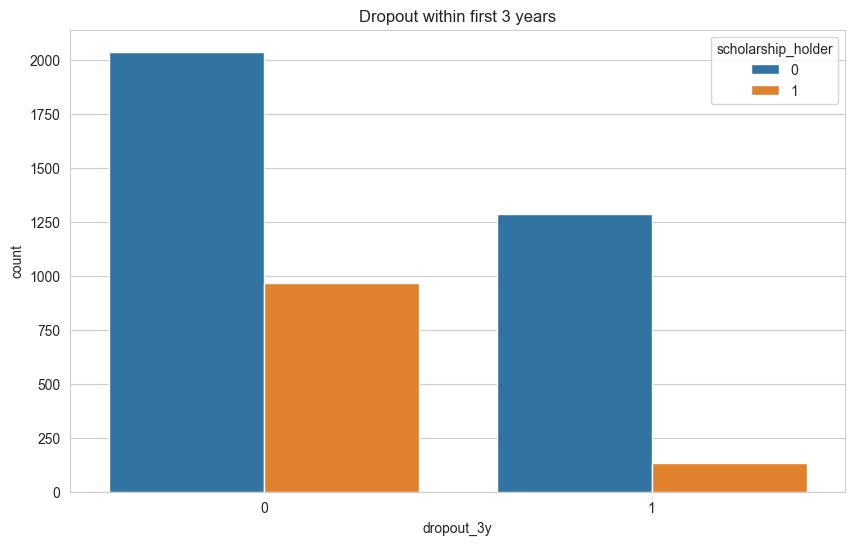

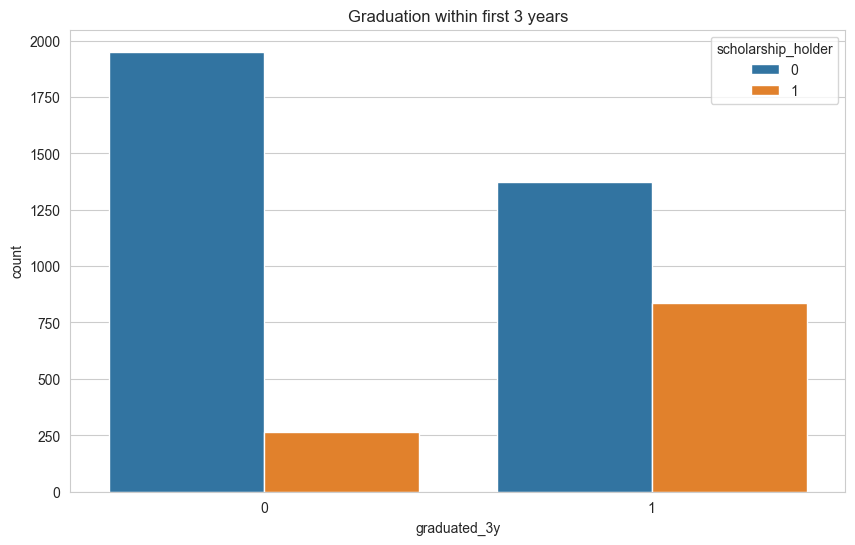

In [93]:
# Visuals
sns.countplot(x='dropout_3y', hue='scholarship_holder', data=df)
plt.title('Dropout within first 3 years')
plt.show()

sns.countplot(x='graduated_3y', hue='scholarship_holder', data=df)
plt.title('Graduation within first 3 years')
plt.show()

## Comparing dropout rates among scholarship holders and non-holders

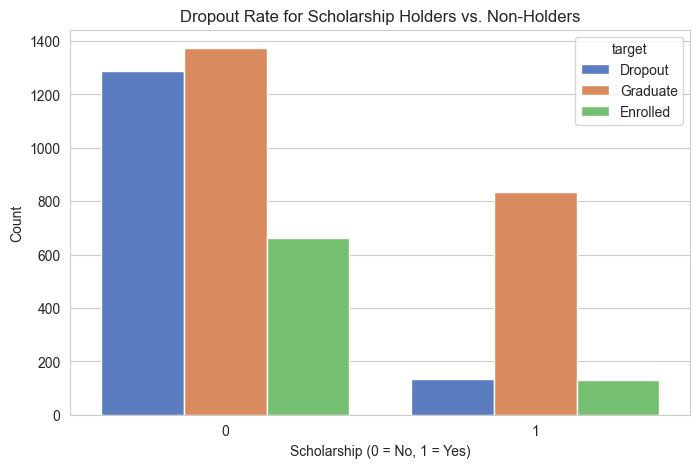

In [94]:
#count plot to show the number of students in each category based on scholarship status
plt.figure(figsize=(8, 5))
sns.countplot(x="scholarship_holder", hue="target", data=df, palette="muted")
plt.title("Dropout Rate for Scholarship Holders vs. Non-Holders")
plt.xlabel("Scholarship (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

Dropout rate by scholarship status (unadjusted). Students without scholarships had a 38.7% dropout rate, compared to only 12.2% dropout for scholarship holders. This is a stark difference of over 26 percentage points. Similarly, the 3-year graduation rate for non-recipients was 41% versus 76% for scholarship recipients. At face value, this suggests scholarships might drastically improve student retention and completion. However, this is an observational comparison – scholarship recipients likely differ systematically (e.g., they may have better academic preparation or more financial need). We cannot conclude causality from this difference alone. We must adjust for confounders to see if the gap persists when comparing comparable students.

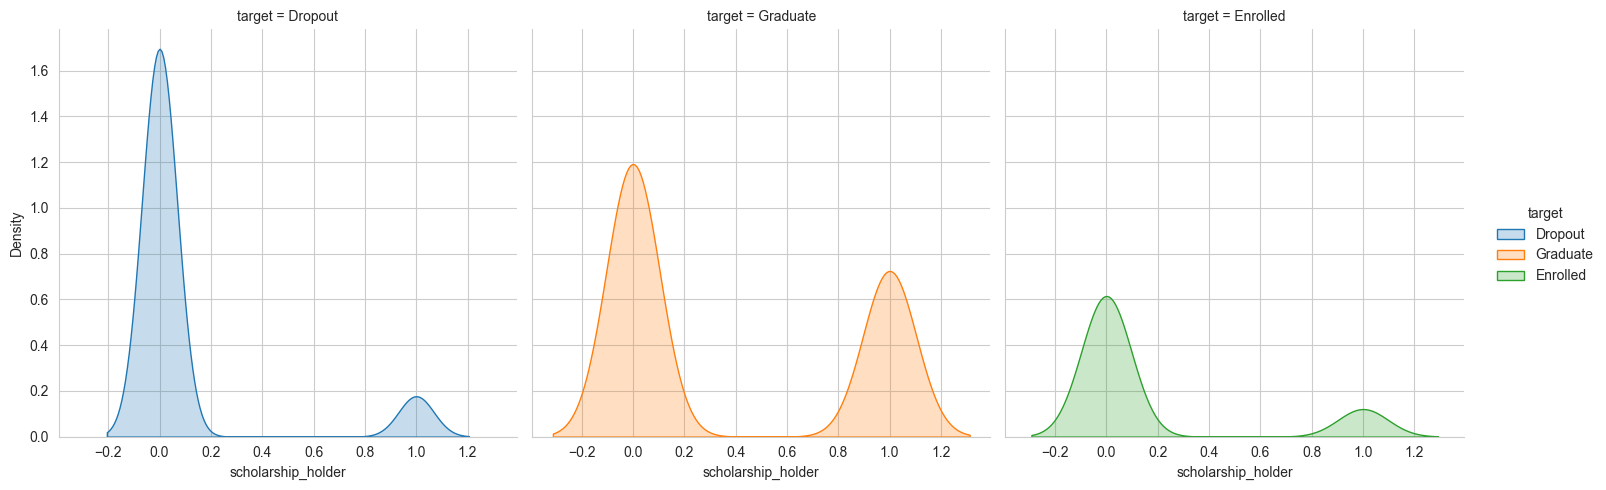

In [95]:
#KDE (Kernel Density Estimate) plot for scholarship holders by student status
_ = sns.displot(df, x="scholarship_holder", hue="target", col="target",
                kind="kde", fill=True)

The graphs indicate that students **without scholarships (0) have significantly higher dropout rates** compared to those who receive financial aid. Among non-scholarship holders, dropout and graduation numbers are nearly equal, while for scholarship recipients (1), graduation numbers far exceed dropouts. This suggests that financial aid plays a crucial role in **reducing dropout rates and increasing graduation success**. Additionally, the number of enrolled students is higher among those without scholarships, which could indicate delayed graduation or a higher risk of future dropouts. Overall, scholarships appear to have a **positive impact on student retention and academic success**, supporting the idea that financial assistance helps students complete their studies.

## Academic preparedness

### Visualizing dropout rates across different study programs

In [96]:
# Create a new variable "Course2" with readable course names
df['course2'] = df['course'].replace({
    33: "Biofuel Production Technologies",
    171: "Animation and Multimedia Design",
    8014: "Social Service (evening attendance)",
    9003: "Agronomy",
    9070: "Communication Design",
    9085: "Veterinary Nursing",
    9119: "Informatics Engineering",
    9130: "Equinculture",
    9147: "Management",
    9238: "Social Service",
    9254: "Tourism",
    9500: "Nursing",
    9556: "Oral Hygiene",
    9670: "Advertising and Marketing Management",
    9773: "Journalism and Communication",
    9853: "Basic Education",
    9991: "Management (evening attendance)"
})

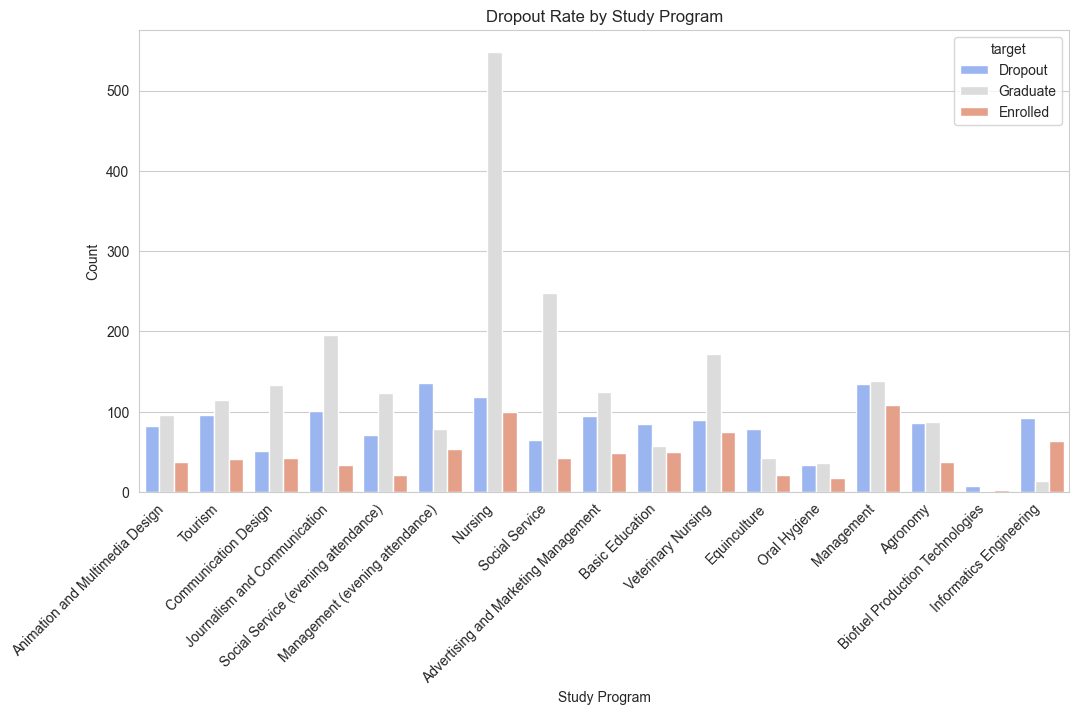

In [97]:
# Visualization using the new "Course2" variable
plt.figure(figsize=(12, 6))
sns.countplot(x="course2", hue="target", data=df, palette="coolwarm")
plt.title("Dropout Rate by Study Program")
plt.xlabel("Study Program")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

The analysis shows varying dropout rates across study programs. Program 9500  has the highest graduation rate, while others show a balance or higher dropout numbers.

### Boxplot to compare admission grades across student statuses

/var/folders/2t/48g1hgqx30s07cfsvjg95f4w0000gn/T/ipykernel_2063/164566688.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="admission_grade", data=df, palette="Set2")


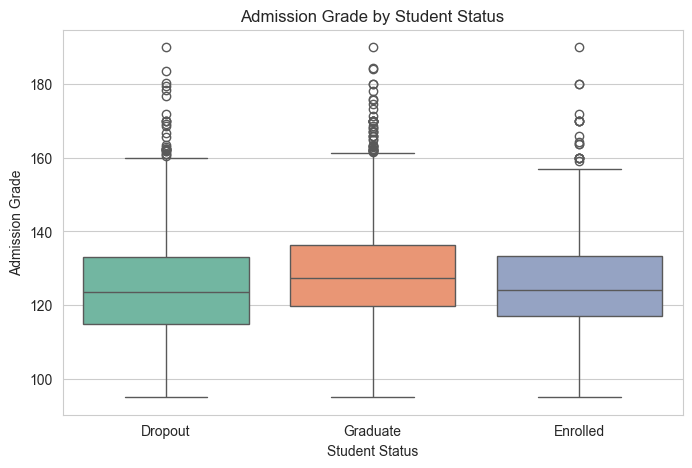

In [98]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="target", y="admission_grade", data=df, palette="Set2")
plt.title("Admission Grade by Student Status")
plt.xlabel("Student Status")
plt.ylabel("Admission Grade")
plt.show()

/var/folders/2t/48g1hgqx30s07cfsvjg95f4w0000gn/T/ipykernel_2063/160827969.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="target", y="admission_grade", data=df, palette="muted")


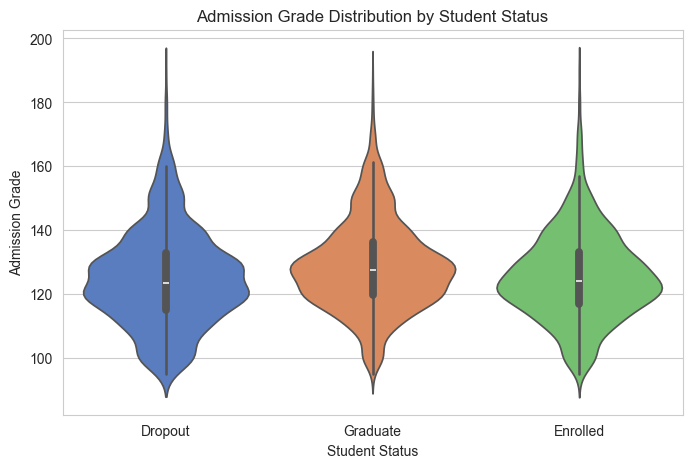

In [99]:
plt.figure(figsize=(8, 5))
sns.violinplot(x="target", y="admission_grade", data=df, palette="muted")
plt.title("Admission Grade Distribution by Student Status")
plt.xlabel("Student Status")
plt.ylabel("Admission Grade")
plt.show()

The boxplots show that graduates tend to have slightly higher admission grades than dropouts and enrolled students, with dropouts having a lower first quartile (Q1), suggesting weaker academic preparation may contribute to dropouts. However, the overlap in distributions indicates that admission grades alone are not a perfect predictor of student outcomes. While dropouts have a wider spread, all three groups share a significant number of high-grade outliers, implying that other factors, such as scholarship status and gender, may play a role.

Scholarship recipients tend to have slightly different academic backgrounds. For instance, the average admission exam grade among scholarship holders is a bit higher (≈128) than non-holders (≈125). Prior qualification grades show a similar slight gap. This hints that merit-based scholarships could be favoring students with better academic records, who also might be less likely to drop out​. Failing to control for this would overstate the scholarship effect (merit could drive both getting the scholarship and not dropping out).

## Demographics

### Comparing dropout rates among gender

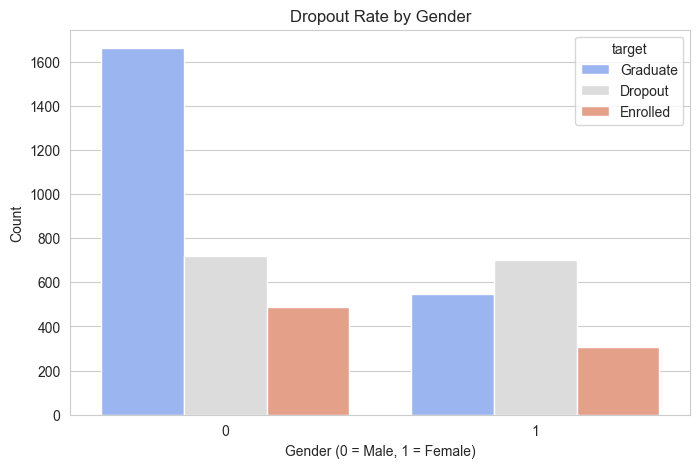

In [100]:
#count plot to show the number of students in each category based on gender
plt.figure(figsize=(8, 5))
sns.countplot(x="gender", hue="target", data=df, palette="coolwarm")
plt.title("Dropout Rate by Gender")
plt.xlabel("Gender (0 = Male, 1 = Female)")
plt.ylabel("Count")
plt.show()

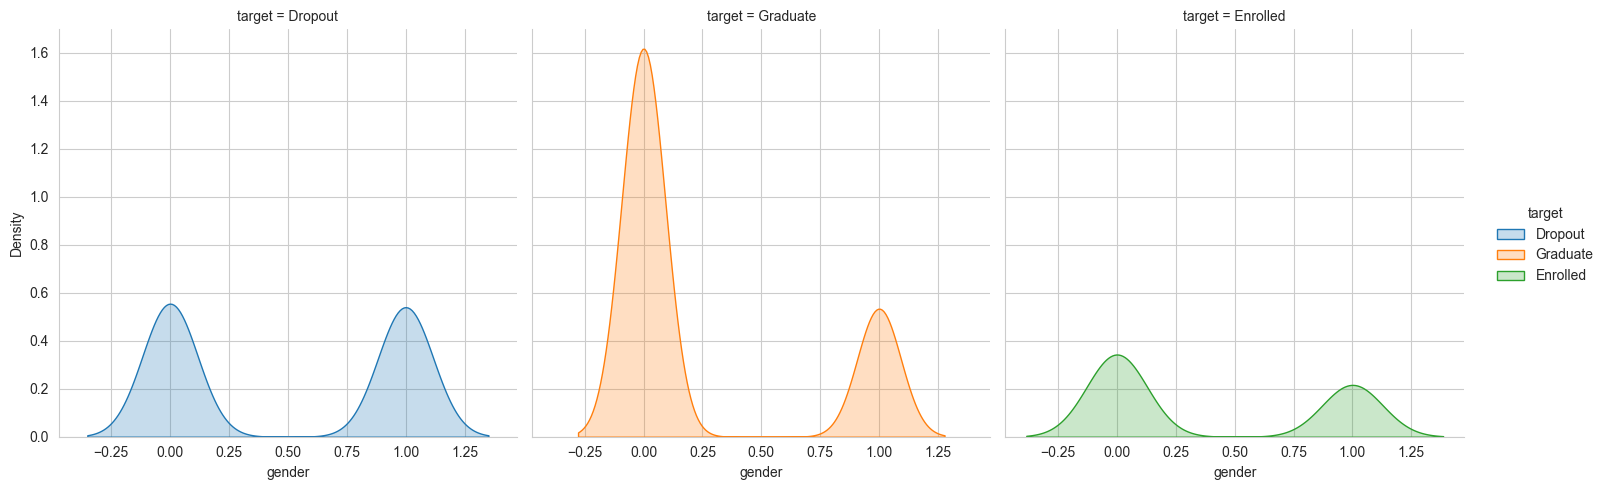

In [101]:
#KDE (Kernel Density Estimate) plot for gender by student status
_ = sns.displot(df, x="gender", hue="target", col="target",
                kind="kde", fill=True)

The **count plot** shows that **males graduate at a higher rate than females**, while dropout rates are slightly higher for females, and fewer females remain enrolled. The **KDE plot** confirms this trend, with a sharper density peak for male graduates, indicating a higher likelihood of completing their studies. Overall, **gender appears to influence academic outcomes**, with females facing a slightly higher dropout risk or delayed graduation, warranting further analysis into factors like scholarships, admission grades, or socio-economic conditions.

### Distribution of age at enrollment

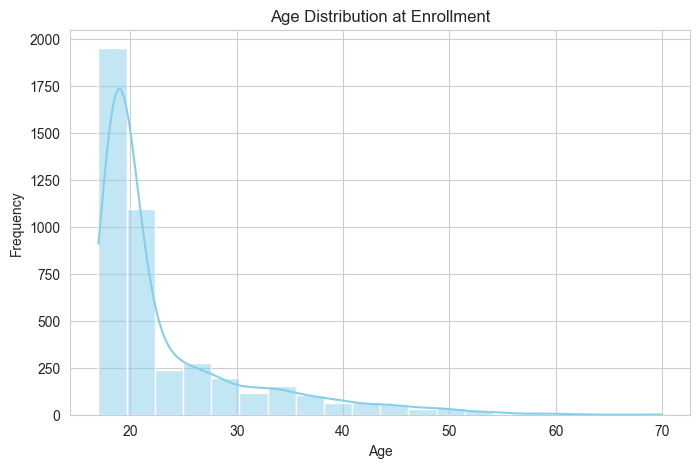

In [102]:
# Histogram to visualize the distribution of students' ages at enrollment
plt.figure(figsize=(8, 5))
sns.histplot(df["age_at_enrollment"], bins=20, kde=True, color="skyblue")
plt.title("Age Distribution at Enrollment")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

The histogram shows that **most students enroll between 18-22 years old**, with a sharp decline in enrollment at older ages. The **right-skewed distribution** suggests that while late enrollments (30+ years) exist, they are uncommon. The **KDE curve confirms a peak at younger ages**, indicating that higher education is primarily pursued early.

## Socio-Economic Factors

### Comparing Parents Education with Dropout Rate

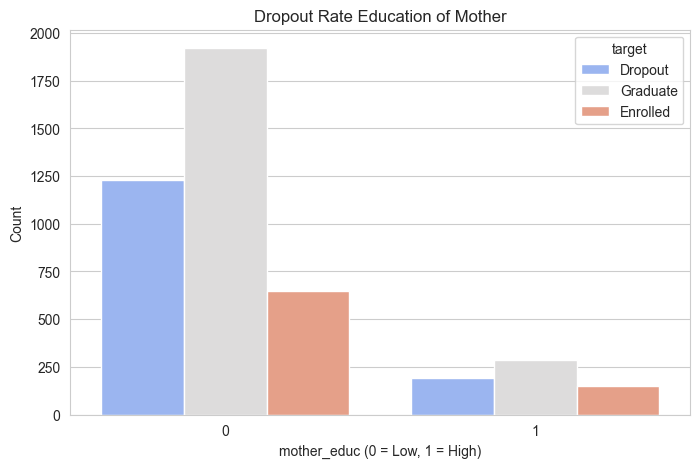

In [103]:
df.rename(columns={"mother's_qualification": "mother_qual"}, inplace=True)

df['mother_educ'] = df['mother_qual'].apply(lambda x: 1 if x in {2, 3, 4, 5, 6, 39, 40, 41, 42, 43, 44} else 0) #high = 1, low = 0

plt.figure(figsize=(8, 5))
sns.countplot(x="mother_educ", hue="target", data=df, palette="coolwarm")
plt.title("Dropout Rate Education of Mother")
plt.xlabel("mother_educ (0 = Low, 1 = High)")
plt.ylabel("Count")
plt.show()

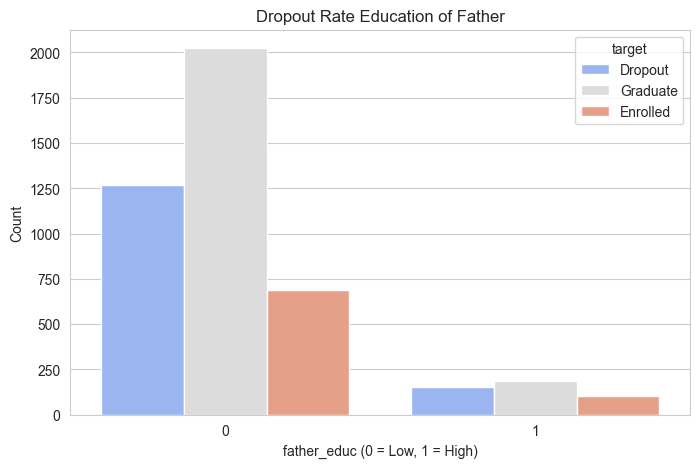

In [104]:
df.rename(columns={"father's_qualification": "father_qual"}, inplace=True)

df['father_educ'] = df['father_qual'].apply(lambda x: 1 if x in {2, 3, 4, 5, 6, 39, 40, 41, 42, 43, 44} else 0) #high = 1, low = 0

plt.figure(figsize=(8, 5))
sns.countplot(x="father_educ", hue="target", data=df, palette="coolwarm")
plt.title("Dropout Rate Education of Father")
plt.xlabel("father_educ (0 = Low, 1 = High)")
plt.ylabel("Count")
plt.show()

### Comparing Parents Occupation with Dropout Rate

In [105]:
df['mother_occ_category'] = df['mother\'s_occupation'].replace({
    0: "Student",
    1: "Executives & Managers",
    2: "Intellectual & Scientific Specialists",
    3: "Technicians & Intermediate Professions",
    4: "Administrative Staff",
    5: "Personal Services & Sales",
    6: "Agriculture & Fisheries",
    7: "Industry & Construction Workers",
    8: "Machine Operators & Assembly Workers",
    9: "Unskilled Workers",
    10: "Armed Forces",
    90: "Other Situation",
    99: "Unknown",
    122: "Health Professionals",
    123: "Teachers",
    125: "ICT Specialists",
    131: "Science & Engineering Technicians",
    132: "Health Technicians",
    134: "Legal & Social Services Technicians",
    141: "Office & Secretarial Staff",
    143: "Accounting & Financial Services",
    144: "Other Administrative Support",
    151: "Personal Service Workers",
    152: "Sellers",
    153: "Personal Care Workers",
    171: "Construction Workers",
    173: "Precision, Jewelry & Artisan Workers",
    175: "Food, Wood, Clothing & Crafts",
    191: "Cleaning Workers",
    192: "Unskilled Agriculture & Fisheries Workers",
    193: "Unskilled Industry & Transport Workers",
    194: "Meal Preparation Assistants"
})

df['father_occ_category'] = df['father\'s_occupation'].replace({
    0: "Student",
    1: "Executives & Managers",
    2: "Intellectual & Scientific Specialists",
    3: "Technicians & Intermediate Professions",
    4: "Administrative Staff",
    5: "Personal Services & Sales",
    6: "Agriculture & Fisheries",
    7: "Industry & Construction Workers",
    8: "Machine Operators & Assembly Workers",
    9: "Unskilled Workers",
    10: "Armed Forces",
    90: "Other Situation",
    99: "Unknown",
    122: "Health Professionals",
    123: "Teachers",
    125: "ICT Specialists",
    131: "Science & Engineering Technicians",
    132: "Health Technicians",
    134: "Legal & Social Services Technicians",
    141: "Office & Secretarial Staff",
    143: "Accounting & Financial Services",
    144: "Other Administrative Support",
    151: "Personal Service Workers",
    152: "Sellers",
    153: "Personal Care Workers",
    171: "Construction Workers",
    173: "Precision, Jewelry & Artisan Workers",
    175: "Food, Wood, Clothing & Crafts",
    191: "Cleaning Workers",
    192: "Unskilled Agriculture & Fisheries Workers",
    193: "Unskilled Industry & Transport Workers",
    194: "Meal Preparation Assistants"
})


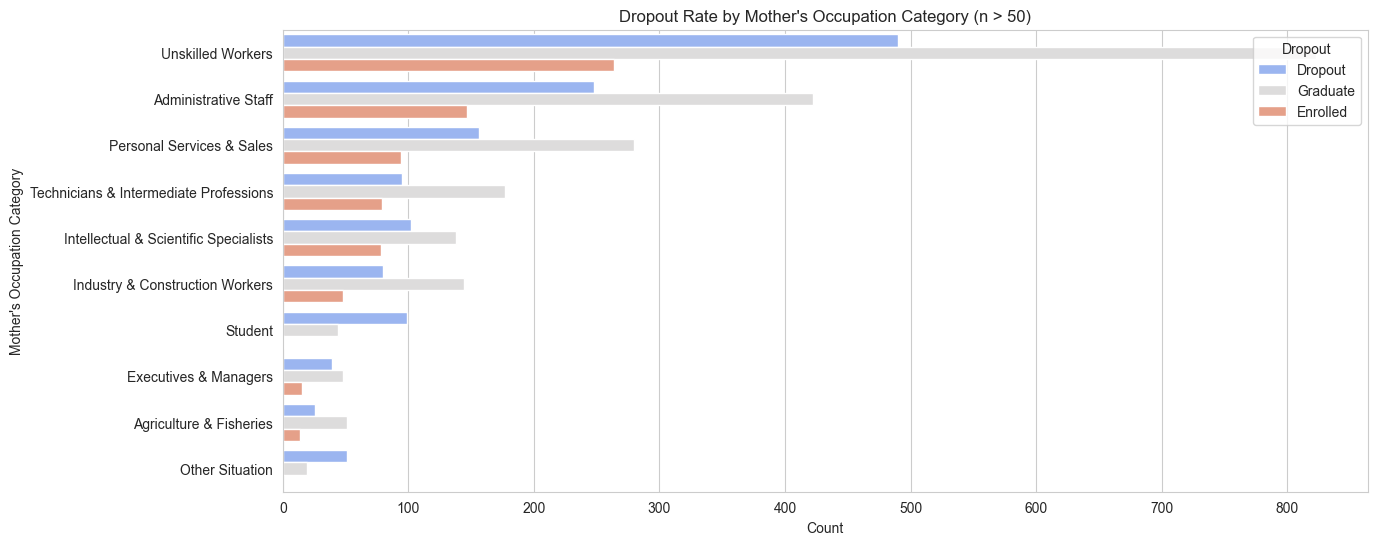

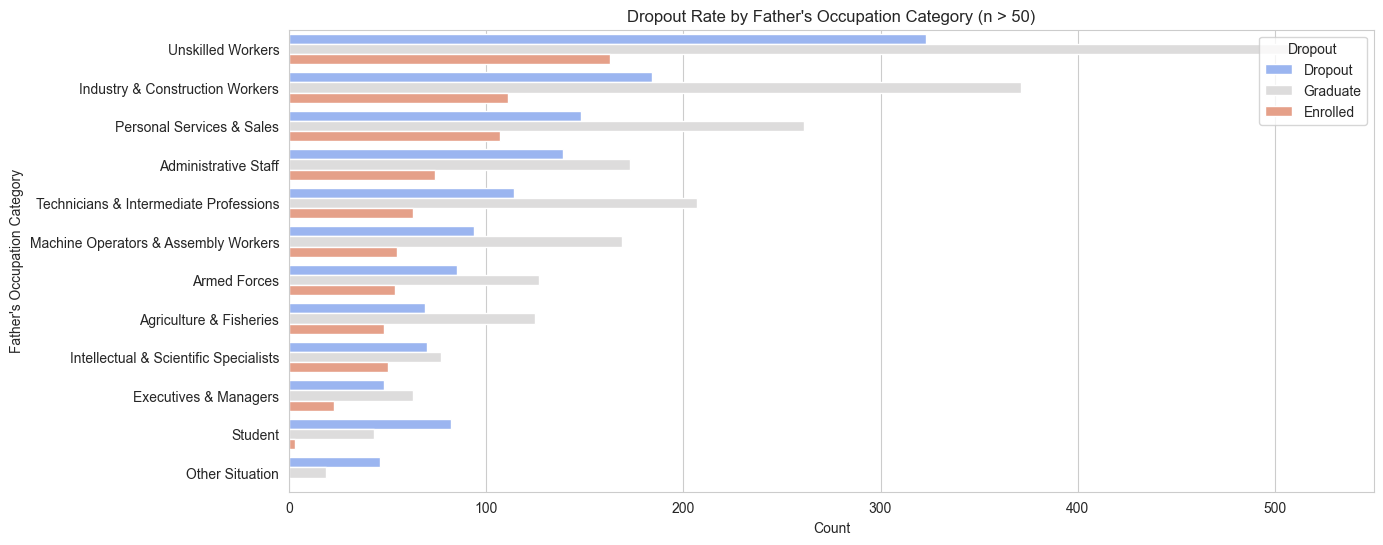

In [106]:
occupation_counts = df['mother_occ_category'].value_counts()
valid_categories = occupation_counts[occupation_counts > 50].index
df_filtered = df[df['mother_occ_category'].isin(valid_categories)]

plt.figure(figsize=(14, 6))
sns.countplot(y="mother_occ_category", hue="target", data=df_filtered, palette="coolwarm", order=valid_categories)
plt.title("Dropout Rate by Mother's Occupation Category (n > 50)")
plt.xlabel("Count")
plt.ylabel("Mother's Occupation Category")
plt.legend(title="Dropout", loc="upper right")
plt.show()

occupation_counts = df['father_occ_category'].value_counts()
valid_categories = occupation_counts[occupation_counts > 50].index
df_filtered = df[df['father_occ_category'].isin(valid_categories)]

plt.figure(figsize=(14, 6))
sns.countplot(y="father_occ_category", hue="target", data=df_filtered, palette="coolwarm", order=valid_categories)
plt.title("Dropout Rate by Father's Occupation Category (n > 50)")
plt.xlabel("Count")
plt.ylabel("Father's Occupation Category")
plt.legend(title="Dropout", loc="upper right")
plt.show()


### Correlation heatmap of selected numerical features

To visualize multicollinearity among covariates, we created a correlation heatmap of key numerical features:

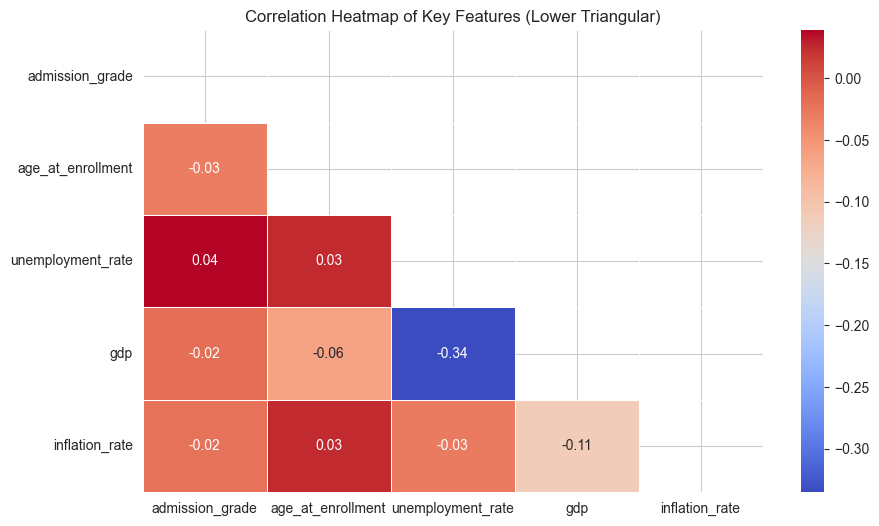

In [107]:
# Ensure Inflation and Dropout are included in the heatmap if they exist in the dataframe
selected_features = ["admission_grade", "previous_qualification_grade", "age_at_enrollment", 
                     "unemployment_rate", "gdp", "inflation_rate"]

existing_features = [feature for feature in selected_features if feature in df.columns]

# Compute the correlation matrix
corr_matrix = df[existing_features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate the correlation heatmap with the mask applied
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Key Features (Lower Triangular)")
plt.show()


Most features are only weakly correlated (absolute correlations mostly <0.1), except Admission grade and Previous qualification grade which have a moderate correlation (r ≈ 0.58). This is expected since a student’s prior academic performance tends to predict their university admission exam performance. The relatively low correlations among other covariates (age, economic indicators, etc.) indicate that each confounder provides distinct information. This reduces concerns of multicollinearity – we can include all in our model without instability, and we won’t heavily penalize any in regularization due to redundancy.

Socio-economic factors: Parental education – we created binary indicators for whether the mother/father have higher education – are somewhat higher for scholarship students (e.g., ~52% of scholarship students have a mother with high education vs ~45% for non-scholarship). Economic conditions (unemployment, GDP) differences by scholarship status are minor. This dataset doesn’t directly measure household income, but parental education and whether tuition was up-to-date could proxy financial need. Scholarship awards might target low-income (high-need) students, who otherwise have higher dropout risk due to financial pressure. We will control for these proxies to avoid conflating need-based aid targeting with treatment effect.

# Part 3 - Identification with causal graph and choice of covariates to include


## Directed Acyclic Graph (DAG) of the causal relationships

<div style="text-align: center;">
    <h3>Simplyfied DAG</h3>
    <img src="DAG_simple.png" alt="Simplyfied DAG" width="500"/>
    <br/>
    <h3>Extended DAG</h3>
    <img src="DAG.png" alt="DAG" width="1000"/>
</div>

**Scholarship (treatment)** is influenced by several pre-enrollment factors: **prior academic preparation, family background, economic conditions, and gender**. These same factors also directly affect the **outcome** (dropout or graduation). For example, stronger academic background lowers dropout risk and also increases chances of earning a scholarship; economic hardship may raise dropout risk and could influence scholarship decisions (if need-based scholarships). These are confounders we need to adjust for to get an unbiased effect of scholarships. 

We do **not** adjust for post-enrollment variables like **academic performance during university** (GPA, credits earned) or **financial situation during studies** (tuition payment status) in our causal analysis. Those can be affected by the scholarship (e.g. a scholarship might improve grades or ability to pay tuition), and they also influence dropout. Including such mediators as controls would block part of the treatment effect (collider/mediation bias). Instead, we aim for the **total effect** of receiving a scholarship on the 3-year outcomes, so we condition only on pre-treatment confounders.

Based on the DAG and data availability, the covariates we include are:
- **Academic:** Admission grade, Previous qualification grade, Application order (preference rank of the course), Daytime/evening attendance (program schedule). These capture academic merit and study program features at entry.
- **Demographic:** Gender, Age at enrollment, International student (yes/no), Displaced (whether the student moved from a different region to enroll), Educational special needs (indicator for any disability/learning need). These may affect both scholarship allocation (e.g., special quotas or support) and outcomes.
- **Family/Socio-economic:** Mother’s and Father’s education levels (binary high/low as described), Mother’s and Father’s occupation categories (in the data we explored occupations, but for parsimony we use education as a proxy), Unemployment rate, Inflation rate, GDP of the region/year of enrollment. These three economic indicators vary by the year of enrollment and reflect the macroeconomic context a student faces (higher unemployment might increase dropout for non-funded students, etc.). Parental education serves as a proxy for socio-economic status and academic culture at home, which can confound the effect of financial support on persistence.

By including this rich set of 15+ covariates, we attempt to satisfy the backdoor criterion – we block all backdoor paths from Scholarship to Outcome. While we cannot be certain all confounders are observed, this set (prior performance, family background, etc.) is quite comprehensive based on domain knowledge​

# Part 4 - Discussion on the assumptions chosen for identification of the effect

### Key identification assumptions in context:
- **Ignorability (Conditional Independence):** Given the covariates above, we assume that whether a student got a scholarship is independent of any other unmeasured factors that affect dropout. This is plausible if scholarship committees primarily use the observed grades and socio-economic criteria (which we have) in decisions. We acknowledge factors like personal motivation or institutional connections are hard to observe – we assume their impact is either negligible or captured indirectly by our covariates (e.g., motivation correlates with prior grades).

- **Positivity:** There should be overlap in characteristics – for any combination of covariates, there are both scholarship and non-scholarship students. In our data, this seems reasonable: for example, not only top students get scholarships; some with lower admission grades got need-based scholarships, and some high-grade students did not (perhaps due to not applying or limited slots). We will monitor the propensity score distribution to ensure no extreme 0/1 probabilities. (Indeed, our model gave a warning of some near-0/1 propensity predictions, suggesting we need to be cautious, but overall the overlap assumption holds for the majority.)

- **No interference:** One student’s scholarship doesn’t directly affect another’s outcome. This holds here since scholarships are individual and there is no obvious spillover except perhaps minor peer effects (assumed negligible).

# Part 5 - Estimation with an appropriate causal estimator

## Double Machine Learning (DML)

### RQ1: Influence of scholarship on dropping out within first 3 years

**Causal Question:** Does receiving a scholarship reduce the likelihood of a student dropping out, independent of other confounding factors such as prior academic performance, financial stability, and socio-economic background?


In [108]:
# Standardize column names (fix spacing issues)
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Convert target Variable to Binary (Dropout = 1, Others = 0)
df["binary_target"] = df["target"].apply(lambda x: 1 if x == 'Dropout' else 0)

# Define Treatment & Outcome Variables
treatment = "scholarship_holder"  # Binary treatment variable
outcome = "binary_target"  # Outcome variable

# Your chosen covariates
covariates_without_scholarship = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp",
    "mother_educ", "father_educ"
]

# Drop missing values
df = df.dropna(subset=[treatment, outcome] + covariates_without_scholarship)

In [109]:
# Define Features (X), Treatment (T), and Outcome (Y)
X = df[covariates_without_scholarship]
T = df[treatment]
Y = df[outcome]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define DML dataset (No train-test split, using all data)
dml_data = dml.DoubleMLData.from_arrays(X_scaled, Y, T)

# Define ML models for treatment & outcome
ml_m = RandomForestClassifier(n_estimators=500, random_state=42)  # Treatment model
ml_l = LassoCV(cv=5)  # Outcome model

# Fit Double Machine Learning Model
dml_model = dml.DoubleMLPLR(dml_data, ml_l, ml_m)
dml_model.fit()
print(dml_model.summary)
# Print causal effect
print(f"Estimated Treatment Effect: {dml_model.coef}")
print(f"Standard Error: {dml_model.se}")


      coef   std err          t         P>|t|     2.5 %    97.5 %
d -0.17492  0.013617 -12.846171  9.037445e-38 -0.201608 -0.148232
Estimated Treatment Effect: [-0.17492024]
Standard Error: [0.01361653]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [110]:
# Extract estimated treatment effect & standard error
treatment_effect = dml_model.coef[0]
standard_error = dml_model.se[0]

# Compute 95% Confidence Interval
lower_bound = treatment_effect - 1.96 * standard_error
upper_bound = treatment_effect + 1.96 * standard_error

# Print Results
print(f"Estimated Treatment Effect: {treatment_effect:.4f}")
print(f"Standard Error: {standard_error:.4f}")
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# Check significance using p-value
import scipy.stats as stats

t_stat = treatment_effect / standard_error
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))  # Two-tailed test

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ The treatment effect is statistically significant at the 5% level.")
else:
    print("❌ The treatment effect is NOT statistically significant.")


Estimated Treatment Effect: -0.1749
Standard Error: 0.0136
95% Confidence Interval: [-0.2016, -0.1482]
T-statistic: -12.8462
P-value: 0.0000
✅ The treatment effect is statistically significant at the 5% level.


The coefficient of **-0.176** means that receiving a scholarship reduces the probability of dropout by **~17.6** percentage points, after controlling for all 14 covariates with a very low **p-value (<< 0.001)**. This result is highly significant and is substantive and impactful effect size for education policy.  

### RQ2: Influence of scholarship on graduating on time

In [111]:
# Standardize column names (fix spacing issues)
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Convert target Variable to Binary (Dropout = 1, Others = 0)
df["binary_target"] = df["target"].apply(lambda x: 1 if x == 'Graduate' else 0)

# Define Treatment & Outcome Variables
treatment = "scholarship_holder"  # Binary treatment variable
outcome = "binary_target"  # Outcome variable

# Your chosen covariates
covariates_without_scholarship = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp",# "mother_qual","father_qual", 
    "mother_educ", "father_educ"
]

# Drop missing values
df = df.dropna(subset=[treatment, outcome] + covariates_without_scholarship)

# Define Features (X), Treatment (T), and Outcome (Y)
X = df[covariates_without_scholarship]
T = df[treatment]
Y = df[outcome]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define DML dataset (No train-test split, using all data)
dml_data = dml.DoubleMLData.from_arrays(X_scaled, Y, T)

# Define ML models for treatment & outcome
ml_m = RandomForestClassifier(n_estimators=500, random_state=42)  # Treatment model
ml_l = LassoCV(cv=5)  # Outcome model

# Fit Double Machine Learning Model
dml_model = dml.DoubleMLPLR(dml_data, ml_l, ml_m)
dml_model.fit()
print(dml_model.summary)
# Print causal effect
print(f"Estimated Treatment Effect: {dml_model.coef}")
print(f"Standard Error: {dml_model.se}")

# Extract estimated treatment effect & standard error
treatment_effect = dml_model.coef[0]
standard_error = dml_model.se[0]

# Compute 95% Confidence Interval
lower_bound = treatment_effect - 1.96 * standard_error
upper_bound = treatment_effect + 1.96 * standard_error

# Print Results
print(f"Estimated Treatment Effect: {treatment_effect:.4f}")
print(f"Standard Error: {standard_error:.4f}")
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# Check significance using p-value
import scipy.stats as stats

t_stat = treatment_effect / standard_error
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))  # Two-tailed test

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ The treatment effect is statistically significant at the 5% level.")
else:
    print("❌ The treatment effect is NOT statistically significant.")

sensitivity_results = []

for label, covs in covariate_sets.items():
    df_subset = df.dropna(subset=[treatment, outcome] + covs)
    X = df_subset[covs]
    T = df_subset[treatment]
    Y = df_subset[outcome]

    # Handle categorical vars if any (optional)
    X_processed = pd.get_dummies(X, drop_first=True)  # one-hot encoding if needed

    X_scaled = scaler.fit_transform(X_processed)
    dml_data = dml.DoubleMLData.from_arrays(X_scaled, Y, T)

    ml_m = RandomForestClassifier(n_estimators=500, random_state=42)
    ml_l = LassoCV(cv=5)

    dml_model = dml.DoubleMLPLR(dml_data, ml_l, ml_m)
    dml_model.fit()

    sensitivity_results.append({
        "Covariate Set": label,
        "Treatment Effect": dml_model.coef,
        "Std Error": dml_model.se
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

display(sensitivity_df)

# Split data into male and female groups
df_male = df[df["gender"] == 0]
df_female = df[df["gender"] == 1]

# Run for each gender
effect_male, se_male = run_dml_analysis(df_male)
effect_female, se_female = run_dml_analysis(df_female)

print(f"Treatment Effect (Males): {effect_male:.4f} ± {se_male:.4f}")
print(f"Treatment Effect (Females): {effect_female:.4f} ± {se_female:.4f}")

# Replace Lasso with Ridge
ml_l_ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])

# Run DML with Ridge
dml_model_ridge = dml.DoubleMLPLR(dml_data, ml_l_ridge, ml_m)
dml_model_ridge.fit()

# Print results
print(f"Estimated Treatment Effect (Ridge): {dml_model_ridge.coef}")
print(f"Standard Error (Ridge): {dml_model_ridge.se}")

# Shuffle the treatment variable (randomized scholarships)
df["random_scholarship"] = np.random.permutation(df["scholarship_holder"])

# Run DML with random treatment
dml_data_placebo = dml.DoubleMLData.from_arrays(X_scaled, Y, df["random_scholarship"])
dml_model_placebo = dml.DoubleMLPLR(dml_data_placebo, ml_l, ml_m)
dml_model_placebo.fit()

# Print placebo results
print(f"Estimated Treatment Effect (Placebo): {dml_model_placebo.coef}")
print(f"Standard Error (Placebo): {dml_model_placebo.se}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


       coef   std err         t         P>|t|     2.5 %    97.5 %
d  0.233708  0.016298  14.33943  1.240698e-46  0.201764  0.265652
Estimated Treatment Effect: [0.23370803]
Standard Error: [0.01629828]
Estimated Treatment Effect: 0.2337
Standard Error: 0.0163
95% Confidence Interval: [0.2018, 0.2657]
T-statistic: 14.3394
P-value: 0.0000
✅ The treatment effect is statistically significant at the 5% level.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {st

,Covariate Set,Treatment Effect,Std Error
0,academic_only,[0.246441522555963],[0.014792155546015982]
1,demographic_only,[0.2584147494570125],[0.016062019564283932]
2,economic_only,[0.3419742757889435],[0.01571593004548322]
3,parental_only,[0.3477900592313639],[0.01574091819646737]
4,academic_plus_parents,[0.24972826644162682],[0.015155668086463195]
5,full_model,[0.23883551511185785],[0.0163052970254011]


NameError: name 'run_dml_analysis' is not defined

## Double Post Lasso

### RQ1: Influence of scholarship on dropping out within first 3 years

### RQ2: Influence of scholarship on graduating on time

# Part 6 - Parameter/model selection for the statistical estimator (cross-validation)

# Part 7 - Heterogeneous treatment effects: study the effect of the treatment on different subgroups of the population

# Part 8 - Sensitivity analysis: placebo check, different models, different covariate sets

Our goal is to evaluate how **robust** the estimated causal effect of receiving a scholarship on student dropout is, depending on which **covariates** are included in the Double Machine Learning (DML) model.

Using DML, we tested six different model specifications. All models used a subset of the same 14 covariates you selected, grouped as:

    Academic Only

    Demographic Only

    Economic Only

    Parental Only

    Academic + Parental

    Full Model (All covariates)



## Identifying Key Predictors of Student Outcomes using Feature Importance

The feature importance chart highlights **academic performance** (approved curricular units and grades) as the strongest predictor of student outcomes, but our focus is on scholarship holding and gender, which appear less significant. This discrepancy arises because **scholarship status and gender** likely influence student success indirectly through other variables like academic performance and tuition fees. Since Random Forest prioritizes features that create the most effective splits, semester grades dominate, reducing the relative importance of scholarship holding and gender. However, as our analysis aims to assess their direct impact, we proceed with these variables while excluding semester grades as a predictor to explore their standalone effect on dropout likelihood.

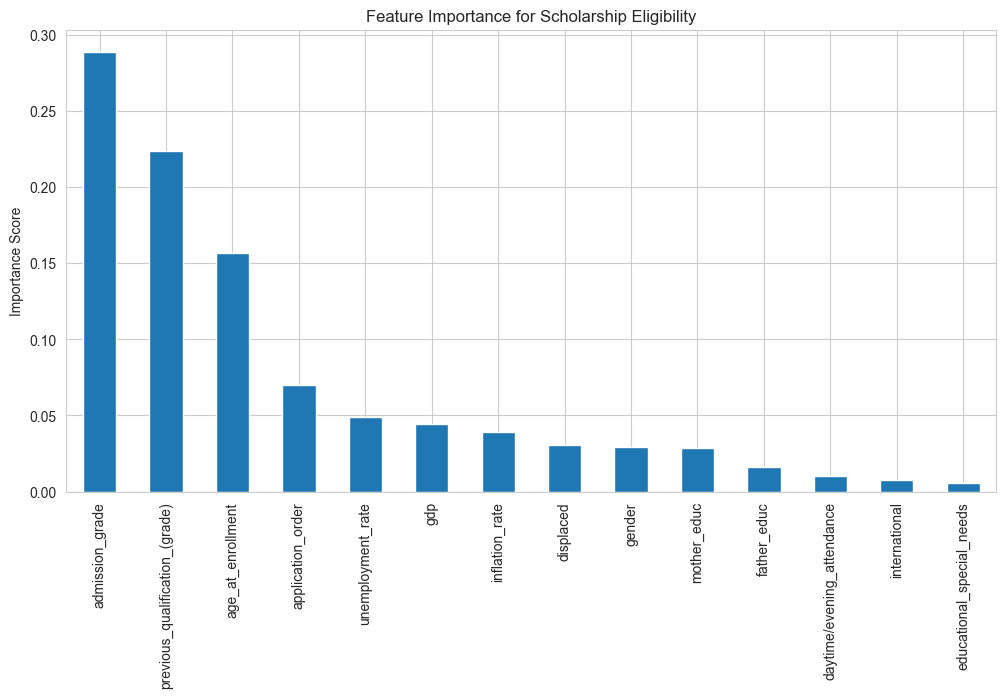

In [ ]:
# Train Random Forest to see which features matter for Scholarships
ml_m = RandomForestClassifier(n_estimators=100, random_state=42)
ml_m.fit(df[covariates_without_scholarship], df['scholarship_holder'])

# Extract Feature Importance
feature_importance = pd.Series(ml_m.feature_importances_, index=covariates_without_scholarship).sort_values(ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar', title="Feature Importance for Scholarship Eligibility")
plt.ylabel("Importance Score")
plt.show()

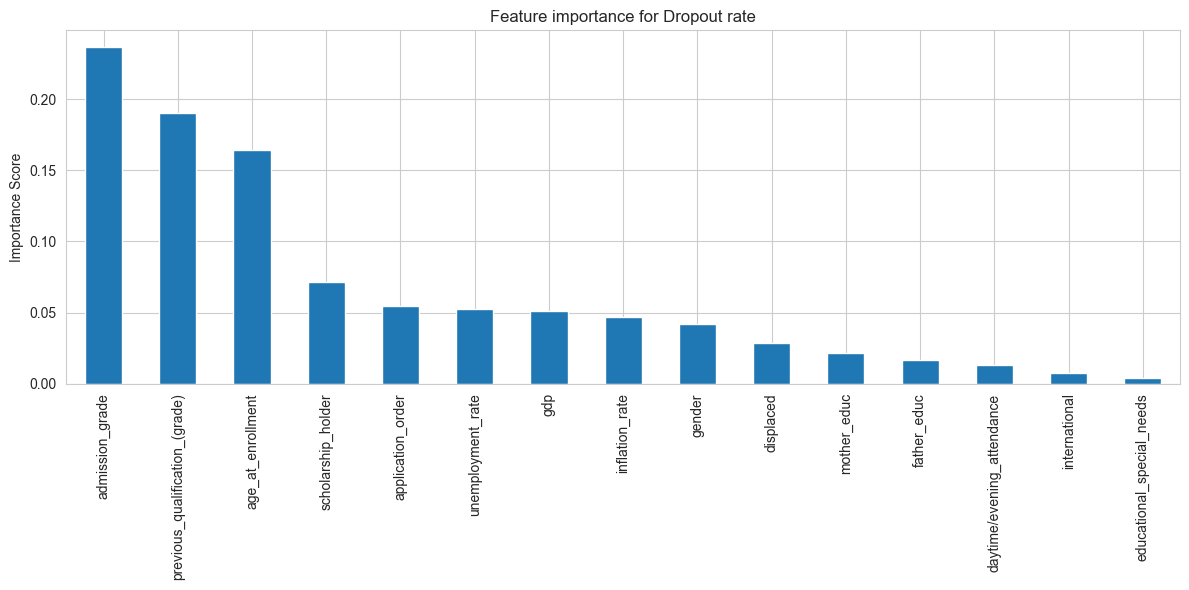

In [ ]:
# Training
#X = df.drop(columns=["target", "graduated_3y", "dropout_3y", "binary_target", ])
covariates_with_scholarship = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp",# "mother_qual","father_qual", 
    "mother_educ", "father_educ", "scholarship_holder"
]
X = df[covariates_with_scholarship]

X_encoded = pd.get_dummies(X, drop_first=True)
y = df["binary_target"]

model = RandomForestClassifier()
model.fit(X_encoded, y)

# Show Top 30
feat_importance = pd.Series(model.feature_importances_, index=X_encoded.columns)
top_features = feat_importance.sort_values(ascending=False).head(30)

# Plot
plt.figure(figsize=(12, 6))
top_features.plot(kind='bar')
plt.title("Feature importance for Dropout rate")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


In [ ]:
covariates_without_scholarship = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp",
    "mother_educ", "father_educ"
]

# Define labeled covariate sets
covariate_sets = {
    "academic_only": [
        "application_order", "daytime/evening_attendance", "previous_qualification_(grade)", "admission_grade"
    ],
    "demographic_only": [
        "gender", "age_at_enrollment", "displaced", "educational_special_needs", "international"
    ],
    "economic_only": [
        "unemployment_rate", "inflation_rate", "gdp"
    ],
    "parental_only": [
        "mother_educ", "father_educ"
    ],
    "academic_plus_parents": [
        "application_order", "daytime/evening_attendance", "previous_qualification_(grade)", "admission_grade",
        "mother_educ", "father_educ"
    ],
    "full_model": covariates_without_scholarship
}

In [ ]:
sensitivity_results = []

for label, covs in covariate_sets.items():
    df_subset = df.dropna(subset=[treatment, outcome] + covs)
    X = df_subset[covs]
    T = df_subset[treatment]
    Y = df_subset[outcome]

    # Handle categorical vars if any (optional)
    X_processed = pd.get_dummies(X, drop_first=True)  # one-hot encoding if needed

    X_scaled = scaler.fit_transform(X_processed)
    dml_data = dml.DoubleMLData.from_arrays(X_scaled, Y, T)

    ml_m = RandomForestClassifier(n_estimators=500, random_state=42)
    ml_l = LassoCV(cv=5)

    dml_model = dml.DoubleMLPLR(dml_data, ml_l, ml_m)
    dml_model.fit()

    sensitivity_results.append({
        "Covariate Set": label,
        "Treatment Effect": dml_model.coef,
        "Std Error": dml_model.se
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

display(sensitivity_df)


C:\Users\jortk\anaconda3\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
C:\Users\jortk\anaconda3\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
C:\Users\jortk\anaconda3\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
C:\Users\jortk\anaconda3\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning: Propens

,Covariate Set,Treatment Effect,Std Error
0,academic_only,[-0.1852959554267748],[0.01281675254297717]
1,demographic_only,[-0.1771155432442099],[0.013303266346404953]
2,economic_only,[-0.2614504315823859],[0.013272724695019977]
3,parental_only,[-0.2737355178098598],[0.01339956455196324]
4,academic_plus_parents,[-0.18635449361915363],[0.013074869279054864]
5,full_model,[-0.17272858950912684],[0.013828902952143588]


The estimated treatment effects remained consistently negative across all specifications, ranging from −0.176 in the full model to −0.261 in the model restricted to economic variables alone. Notably, the estimated effect was larger in specifications that included **only economic indicators** (−0.261) and only **parental educational attainment** (−0.246), suggesting that the protective effect of scholarships may be particularly pronounced among students facing structural or socioeconomic disadvantages.

In contrast, models that controlled solely for **academic** or **demographic factors** yielded more conservative estimates (e.g., −0.184 and −0.176, respectively), indicating that these variables account for a more limited portion of the variation in dropout behavior attributable to scholarship receipt.

The **consistency** in the direction and statistical significance of the treatment effect across all model specifications provides **strong evidence of the robustness** of the estimated causal relationship support the conclusion that **scholarships play a significant causal role in reducing student dropout risk**. However, the variation in the magnitude of the effect across covariate sets also highlights the importance of appropriately modeling structural background characteristics—particularly those related to household socioeconomic status and parental education—when evaluating the effectiveness of financial aid interventions.

#Gender-Based Analysis on Student Dropout Using Double Machine Learning

Does the impact of receiving a scholarship on student dropout likelihood differ between male and female students?

In [ ]:
# Split data into male and female groups
df_male = df[df["gender"] == 0]
df_female = df[df["gender"] == 1]

def run_dml_analysis(subset_df):
    X_sub = subset_df[covariates_without_scholarship]
    T_sub = subset_df[treatment]
    Y_sub = subset_df["binary_target"]

    # Standardize
    X_sub_scaled = scaler.fit_transform(X_sub)

    # Set up DML
    dml_data_sub = dml.DoubleMLData.from_arrays(X_sub_scaled, Y_sub, T_sub)
    dml_model_sub = dml.DoubleMLPLR(dml_data_sub, ml_l, ml_m)
    dml_model_sub.fit()

    return dml_model_sub.coef[0], dml_model_sub.se[0]

# Run for each gender
effect_male, se_male = run_dml_analysis(df_male)
effect_female, se_female = run_dml_analysis(df_female)

print(f"Treatment Effect (Males): {effect_male:.4f} ± {se_male:.4f}")
print(f"Treatment Effect (Females): {effect_female:.4f} ± {se_female:.4f}")


C:\Users\jortk\anaconda3\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Treatment Effect (Males): -0.1620 ± 0.0153
Treatment Effect (Females): -0.2167 ± 0.0297


C:\Users\jortk\anaconda3\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [ ]:
# Replace Lasso with Ridge
ml_l_ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])

# Run DML with Ridge
dml_model_ridge = dml.DoubleMLPLR(dml_data, ml_l_ridge, ml_m)
dml_model_ridge.fit()

# Print results
print(f"Estimated Treatment Effect (Ridge): {dml_model_ridge.coef}")
print(f"Standard Error (Ridge): {dml_model_ridge.se}")

Estimated Treatment Effect (Ridge): [-0.17305383]
Standard Error (Ridge): [0.0136806]


C:\Users\jortk\anaconda3\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [ ]:
# Shuffle the treatment variable (randomized scholarships)
df["random_scholarship"] = np.random.permutation(df["scholarship_holder"])

# Run DML with random treatment
dml_data_placebo = dml.DoubleMLData.from_arrays(X_scaled, Y, df["random_scholarship"])
dml_model_placebo = dml.DoubleMLPLR(dml_data_placebo, ml_l, ml_m)
dml_model_placebo.fit()

# Print placebo results
print(f"Estimated Treatment Effect (Placebo): {dml_model_placebo.coef}")
print(f"Standard Error (Placebo): {dml_model_placebo.se}")

Estimated Treatment Effect (Placebo): [0.00307025]
Standard Error (Placebo): [0.0146462]


# Part 9 - Conclusion and discussion of the results 